Loaded Data from:  1
Loaded Data from:  2
Loaded Data from:  3
互信息分布图已保存至: ./MI_Distribution_H_NMR_and_IR.png


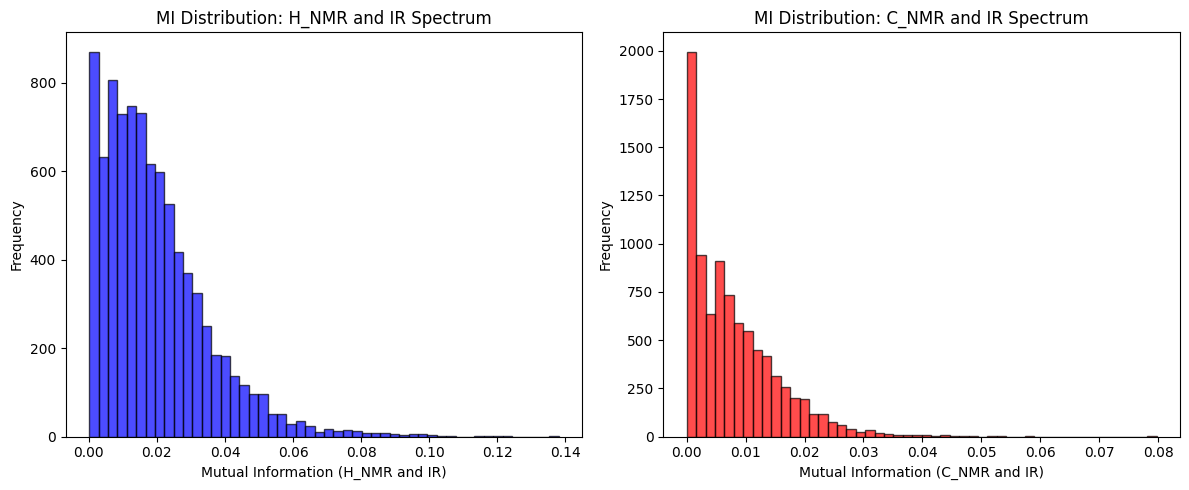

X_train shape: (8740, 3, 600)
y_train shape: (8740,)
X_test shape: (972, 3, 600)
y_test shape: (972,)
[[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 3.35999997e-04  6.29879625e-03 -1.59160266e-03 ... -6.41971687e-04
    6.61649423e-04 -6.56999939e-04]]

 [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 4.54299990e-03  7.19435245e-03  3.89051575e-03 ... -3.71674459e-04
   -4.56636048e-04 -4.57999995e-04]]

 [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 ...  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 1.75160002e-02  1.74263473e-02  1.

Epoch 1/41:  47%|████▋     | 100/214 [00:13<00:14,  7.69batch/s, kl_weight=0.1, loss=2.43]


KeyboardInterrupt: 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import pandas as pd
import pickle
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from pathlib import Path
from rdkit import Chem
from rdkit import RDLogger
from scipy.interpolate import interp1d
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mutual_info_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mutual_info_score

# 假设 train 已加载
# train.shape = (8740, 3, 600)

def compute_mi_distribution(train):
    num_molecules = train.shape[0]  # 8740
    mi_1_3 = []  # 存储第一维 vs 第三维的 MI
    mi_2_3 = []  # 存储第二维 vs 第三维的 MI
    bins = 30  # 分箱数

    for i in range(num_molecules):
        x1 = train[i, 0, :]  # 第一维光谱
        x2 = train[i, 1, :]  # 第二维光谱
        x3 = train[i, 2, :]  # 第三维光谱

        # 进行等间距分箱
        x1_binned = np.digitize(x1, bins=np.linspace(x1.min(), x1.max(), bins))
        x2_binned = np.digitize(x2, bins=np.linspace(x2.min(), x2.max(), bins))
        x3_binned = np.digitize(x3, bins=np.linspace(x3.min(), x3.max(), bins))

        # 计算互信息
        mi_1_3.append(mutual_info_score(x1_binned, x3_binned))
        mi_2_3.append(mutual_info_score(x2_binned, x3_binned))

    return np.array(mi_1_3), np.array(mi_2_3)

# Disable RDLogger warnings
RDLogger.DisableLog('rdApp.*')
import os

os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
functional_groups = {
    'Acid anhydride': Chem.MolFromSmarts('[CX3](=[OX1])[OX2][CX3](=[OX1])'),
    'Acyl halide': Chem.MolFromSmarts('[CX3](=[OX1])[F,Cl,Br,I]'),
    'Alcohol': Chem.MolFromSmarts('[#6][OX2H]'),
    'Aldehyde': Chem.MolFromSmarts('[CX3H1](=O)[#6,H]'),
    'Alkane': Chem.MolFromSmarts('[CX4;H3,H2]'),
    'Alkene': Chem.MolFromSmarts('[CX3]=[CX3]'),
    'Alkyne': Chem.MolFromSmarts('[CX2]#[CX2]'),
    'Amide': Chem.MolFromSmarts('[NX3][CX3](=[OX1])[#6]'),
    'Amine': Chem.MolFromSmarts('[NX3;H2,H1,H0;!$(NC=O)]'),
    'Arene': Chem.MolFromSmarts('[cX3]1[cX3][cX3][cX3][cX3][cX3]1'),
    'Azo compound': Chem.MolFromSmarts('[#6][NX2]=[NX2][#6]'),
    'Carbamate': Chem.MolFromSmarts('[NX3][CX3](=[OX1])[OX2H0]'),
    'Carboxylic acid': Chem.MolFromSmarts('[CX3](=O)[OX2H]'),
    'Enamine': Chem.MolFromSmarts('[NX3][CX3]=[CX3]'),
    'Enol': Chem.MolFromSmarts('[OX2H][#6X3]=[#6]'),
    'Ester': Chem.MolFromSmarts('[#6][CX3](=O)[OX2H0][#6]'),
    'Ether': Chem.MolFromSmarts('[OD2]([#6])[#6]'),
    'Haloalkane': Chem.MolFromSmarts('[#6][F,Cl,Br,I]'),
    'Hydrazine': Chem.MolFromSmarts('[NX3][NX3]'),
    'Hydrazone': Chem.MolFromSmarts('[NX3][NX2]=[#6]'),
    'Imide': Chem.MolFromSmarts('[CX3](=[OX1])[NX3][CX3](=[OX1])'),
    'Imine': Chem.MolFromSmarts('[$([CX3]([#6])[#6]),$([CX3H][#6])]=[$([NX2][#6]),$([NX2H])]'),
    'Isocyanate': Chem.MolFromSmarts('[NX2]=[C]=[O]'),
    'Isothiocyanate': Chem.MolFromSmarts('[NX2]=[C]=[S]'),
    'Ketone': Chem.MolFromSmarts('[#6][CX3](=O)[#6]'),
    'Nitrile': Chem.MolFromSmarts('[NX1]#[CX2]'),
    'Phenol': Chem.MolFromSmarts('[OX2H][cX3]:[c]'),
    'Phosphine': Chem.MolFromSmarts('[PX3]'),
    'Sulfide': Chem.MolFromSmarts('[#16X2H0]'),
    'Sulfonamide': Chem.MolFromSmarts('[#16X4]([NX3])(=[OX1])(=[OX1])[#6]'),
    'Sulfonate': Chem.MolFromSmarts('[#16X4](=[OX1])(=[OX1])([#6])[OX2H0]'),
    'Sulfone': Chem.MolFromSmarts('[#16X4](=[OX1])(=[OX1])([#6])[#6]'),
    'Sulfonic acid': Chem.MolFromSmarts('[#16X4](=[OX1])(=[OX1])([#6])[OX2H]'),
    'Sulfoxide': Chem.MolFromSmarts('[#16X3]=[OX1]'),
    'Thial': Chem.MolFromSmarts('[CX3H1](=S)[#6,H]'),
    'Thioamide': Chem.MolFromSmarts('[NX3][CX3]=[SX1]'),
    'Thiol': Chem.MolFromSmarts('[#16X2H]')
}
def match_group(mol: Chem.Mol, func_group) -> int:
    if type(func_group) == Chem.Mol:
        n = len(mol.GetSubstructMatches(func_group))
    else:
        n = func_group(mol)
    return 0 if n == 0 else 1
# Function to map SMILES to functional groups (no change)
def get_functional_groups(smiles: str) -> dict:
    smiles = smiles.strip().replace(' ', '')
    mol = Chem.MolFromSmiles(smiles)
    if mol is None: 
        return None
    func_groups = [match_group(mol, smarts) for smarts in functional_groups.values()]
    return func_groups

def interpolate_to_600(spec):
    old_x = np.arange(len(spec))
    new_x = np.linspace(min(old_x), max(old_x), 600)
    interp = interp1d(old_x, spec)
    return interp(new_x)

def make_msms_spectrum(spectrum):
    msms_spectrum = np.zeros(10000)
    for peak in spectrum:
        peak_pos = int(peak[0]*10)
        peak_pos = min(peak_pos, 9999)
        msms_spectrum[peak_pos] = peak[1]
    return msms_spectrum

# Define CNN Model in PyTo




import torch
import torch.nn as nn
import torch.nn.functional as F



class IndependentCNN_main(nn.Module):
    def __init__(self, num_fgs):
        super(IndependentCNN_main, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=31, kernel_size=11, padding='same')
        self.conv2 = nn.Conv1d(in_channels=31, out_channels=62, kernel_size=11, padding='same')

        self.batch_norm1 = nn.BatchNorm1d(31)
        self.batch_norm2 = nn.BatchNorm1d(62)

        # MLP for selecting important channels (62 channels)
        self.mlp = nn.Sequential(
            nn.Linear(62, 128),  # 输入每个通道150个特征
            nn.ReLU(),
            nn.Linear(128, 1)     # 输出每个通道的重要性评分
        )

    def compress(self, solute_features):
        p = self.mlp(solute_features)
        device = solute_features.device
        temperature = 1.0
        bias = 0.0001  # 避免 bias 为 0 导致的问题
        eps = (bias - (1 - bias)) * torch.rand(p.size()) + (1 - bias)
        gate_inputs = torch.log(eps) - torch.log(1 - eps)
        gate_inputs = gate_inputs.to(device)
        gate_inputs = (gate_inputs + p) / temperature
        gate_inputs = torch.sigmoid(gate_inputs).squeeze()
        p = torch.sigmoid(p)
        return gate_inputs, p

    def forward(self, x):
        # 卷积与批归一化
        x = F.relu(self.batch_norm1(self.conv1(x)))
        x = F.max_pool1d(x, 2)  # 池化大小为1，不改变尺寸
        x = F.relu(self.batch_norm2(self.conv2(x)))
        x = F.max_pool1d(x, 2)  # 池化大小为4，减少特征维度
        x = x.permute(0, 2, 1)  # 调整维度顺序

        # 复制特征图
        static_feature_map = x.clone().detach()
        channel_means = x.mean(dim=1)
        channel_std = x.std(dim=1)

        # 压缩与门控
        channel_importance, p = self.compress(x)
        channel_importance = channel_importance.unsqueeze(-1)

        # **修改部分开始**
        # 将不重要的部分置为0，而不是均值
        ib_x_mean = x * channel_importance  # 去除 (1 - channel_importance) * channel_means.unsqueeze(1)
        ib_x_std = (1 - channel_importance) * channel_std.unsqueeze(1)
        ib_x = ib_x_mean + torch.rand_like(ib_x_mean) * ib_x_std
        # **修改部分结束**

        # KL 散度损失计算
        epsilon = 1e-8
        KL_tensor = 0.5 * (
            (ib_x_std**2) / (channel_std.unsqueeze(1) + epsilon)**2 +
            (channel_std.unsqueeze(1)**2) / (ib_x_std + epsilon)**2 - 1
        ) + (ib_x_mean**2) / (channel_std.unsqueeze(1) + epsilon)**2  # 修改了这里，将 (ib_x_mean - 0)**2 替换为 ib_x_mean**2

        KL_Loss = torch.mean(KL_tensor)

        # 调整维度顺序并返回
        ib_x = ib_x.permute(0, 2, 1)
        return ib_x, KL_Loss, p


class IndependentCNN_assit(nn.Module):
    def __init__(self, num_fgs):
        super(IndependentCNN_assit, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=31, kernel_size=11, padding='same')
        self.conv2 = nn.Conv1d(in_channels=31, out_channels=62, kernel_size=11, padding='same')

        self.batch_norm1 = nn.BatchNorm1d(31)
        self.batch_norm2 = nn.BatchNorm1d(62)

        # MLP for selecting important channels (62 channels)
        self.mlp = nn.Sequential(
            nn.Linear(62, 128),  # 输入每个通道150个特征
            nn.ReLU(),
            nn.Linear(128, 1)     # 输出每个通道的重要性评分
        )

    def compress(self, solute_features):
        p = self.mlp(solute_features)
        device = solute_features.device
        temperature = 1.0
        bias = 0.0001  # 避免 bias 为 0 导致的问题
        eps = (bias - (1 - bias)) * torch.rand(p.size()) + (1 - bias)
        gate_inputs = torch.log(eps) - torch.log(1 - eps)
        gate_inputs = gate_inputs.to(device)
        gate_inputs = (gate_inputs + p) / temperature
        gate_inputs = torch.sigmoid(gate_inputs).squeeze()
        p = torch.sigmoid(p)
        return gate_inputs, p

    def forward(self, x,x3):
        #CGIB的之所以能与噪音直接做损失，是因为他GIB是通过互信息的两项预测出来的。
        # 卷积与批归一化
        x=x+x3
        x = F.relu(self.batch_norm1(self.conv1(x)))
        x = F.max_pool1d(x, 2)  # 池化大小为1，不改变尺寸
        x = F.relu(self.batch_norm2(self.conv2(x)))
        x = F.max_pool1d(x, 2)  # 池化大小为4，减少特征维度
        x = x.permute(0, 2, 1)  # 调整维度顺序

        # 复制特征图
        static_feature_map = x.clone().detach()
        channel_means = x.mean(dim=1)
        channel_std = x.std(dim=1)

        # 压缩与门控
        channel_importance, p = self.compress(x)
        channel_importance = channel_importance.unsqueeze(-1)

        # **修改部分开始**
        # 将不重要的部分置为0，而不是均值
        ib_x_mean = x * channel_importance  # 去除 (1 - channel_importance) * channel_means.unsqueeze(1)
        ib_x_std = (1 - channel_importance) * channel_std.unsqueeze(1)
        ib_x = ib_x_mean + torch.rand_like(ib_x_mean) * ib_x_std
        # **修改部分结束**

        # KL 散度损失计算
        epsilon = 1e-8
        KL_tensor = 0.5 * (
            (ib_x_std**2) / (channel_std.unsqueeze(1) + epsilon)**2 +
            (channel_std.unsqueeze(1)**2) / (ib_x_std + epsilon)**2 - 1
        ) + (ib_x_mean**2) / (channel_std.unsqueeze(1) + epsilon)**2  # 修改了这里，将 (ib_x_mean - 0)**2 替换为 ib_x_mean**2

        KL_Loss = torch.mean(KL_tensor)

        # 调整维度顺序并返回
        ib_x = ib_x.permute(0, 2, 1)
        return ib_x, KL_Loss, p

def rbf_kernel(x, y, sigma=1.0):
    """
    x: [B, D]
    y: [B, D]
    sigma: RBF 核的带宽 (可调)
    返回: [B, B] 的核矩阵
    """
    # x.unsqueeze(1): [B, 1, D]
    # y.unsqueeze(0): [1, B, D]
    # dist: [B, B]，表示 x_i 与 y_j 的欧式距离平方
    x = x.unsqueeze(1)
    y = y.unsqueeze(0)
    dist = (x - y).pow(2).sum(dim=2)
    kxy = torch.exp(-dist / (2 * sigma**2))
    return kxy

# =============== 2. 定义 HSIC 计算函数 ===============
def hsic(x, y, sigma=1.0):
    """
    计算 x, y 的 HSIC 值: HSIC(X, Y) = 1/(n-1)^2 * Tr(H Kx H Ky)
    x: [B, D]
    y: [B, D]
    sigma: RBF 核带宽
    返回标量 HSIC 值
    """
    assert x.size(0) == y.size(0), "x,y 的 batch size 不一致"
    n = x.size(0)

    # 计算核矩阵
    Kx = rbf_kernel(x, x, sigma=sigma)
    Ky = rbf_kernel(y, y, sigma=sigma)

    # 居中矩阵 H = I - 1/n
    H = torch.eye(n, device=x.device) - (1./n) * torch.ones((n, n), device=x.device)

    # H Kx H
    HKxH = H.mm(Kx).mm(H)

    # HSIC = Tr( (H Kx H) * Ky ) / (n-1)^2
    # 注: 这里相乘可以写为 trace(HKxH @ Ky)，矩阵乘法后再 trace
    hsic_val = torch.trace(HKxH.mm(Ky)) / (float(n - 1) ** 2)

    return hsic_val









import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNModelWithVAE(nn.Module): 
    def __init__(self, num_fgs, channel=62, feature_dim=150, hidden_dim=256, latent_dim=64, m_dim=10):
        """
        参数：
        - num_fgs: 预测目标的维度
        - channel: 每个光谱的通道数（不同频率段）
        - feature_dim: 每个光谱的特征维度
        - hidden_dim: 隐藏层维度
        - latent_dim: 潜在变量 z 的维度
        - m_dim: 预测目标的维度（如有需要）
        """
        super(CNNModelWithVAE, self).__init__()
        self.channel = channel
        self.feature_dim = feature_dim

        # 创建三个独立的CNN模块
        self.cnn1 = IndependentCNN_assit(num_fgs)
        self.cnn2 = IndependentCNN_assit(num_fgs)
        self.cnn3 = IndependentCNN_main(num_fgs)


        # VAE Encoder: 将三个光谱特征融合成潜在表示 z
        # 将 [B, 3*channel, feature_dim] 展平为 [B, 3*channel*feature_dim]
        self.fc_fusion = nn.Sequential(
            nn.Linear(3 * channel * feature_dim, hidden_dim),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

        # VAE Decoder: 从潜在表示 z 重建三个光谱
        self.decoder = nn.ModuleList([
            nn.Sequential(
                nn.Linear(latent_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, channel * feature_dim),
                nn.ReLU()
            ) for _ in range(3)
        ])


        # 增加一个线性层处理 x3 的特征
        self.fc_x3 = nn.Linear(channel * feature_dim, latent_dim)

        # 全连接层用于最终预测，使用 z 和 x3 作为输入
        self.fc1 = nn.Linear(latent_dim *2, 4927)  # z 和 x3
        self.fc2 = nn.Linear(4927, 2785)
        self.fc3 = nn.Linear(2785, 1574)
        self.fc4 = nn.Linear(1574, num_fgs)
        self.dropout = nn.Dropout(0.48599073736368)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)   # ~ N(0, I)
        return mu + std * eps
    
    def forward(self, x):
        """
        前向传播函数。
        
        参数：
        - x: 输入张量，形状为 [batch_size, 3, feature_dim]
        
        返回：
        - 一个包含预测结果和各类损失组件的字典
        """
        # 拆分输入为三个光谱通道
        x1, x2, x3 = x[:, 0:1, :], x[:, 1:2, :], x[:, 2:3, :]  # 每个 [B, 1, feature_dim]

        # 分别通过三个独立的CNN
        ib_x_1, kl_loss1,channal_importance_1= self.cnn1(x1,x3)  # [B, channel, feature_dim]
        ib_x_2, kl_loss2 ,channal_importance_2= self.cnn2(x2,x3)
        ib_x_3, kl_loss3 ,channal_importance_3= self.cnn3(x3)

        # 将三个通道的输出堆叠
        ib_x_stacked = torch.cat([ib_x_1, ib_x_2, ib_x_3], dim=1)  # [B, 3*channel, feature_dim]
        # 展平为 [B, 3*channel*feature_dim]
        ib_x_flat = ib_x_stacked.view(ib_x_stacked.size(0), -1)  # [B, 3*channel*feature_dim]
        # VAE Encoder
        h = self.fc_fusion(ib_x_flat)  # [B, hidden_dim]
        mu = self.fc_mu(h)             # [B, latent_dim]
        logvar = self.fc_logvar(h)     # [B, latent_dim]
        z = self.reparameterize(mu, logvar)  # [B, latent_dim]

        # VAE Decoder: 重建三个光谱
        recon_x = []
        for decoder in self.decoder:
            recon = decoder(z)  # [B, channel * feature_dim]
            recon = recon.view(z.size(0), self.channel, self.feature_dim)  # [B, channel, feature_dim]
            recon_x.append(recon)
        recon_x1, recon_x2, recon_x3 = recon_x  # 各自的重构光谱

        # 条件互信息估计器
        # 将 ib_x_* 展平
        ib_x1_flat = ib_x_1.view(z.size(0), -1)  # [B, channel * feature_dim]
        ib_x2_flat = ib_x_2.view(z.size(0), -1)
        ib_x3_flat = ib_x_3.view(z.size(0), -1)
        sigma=1.0

        # 增加 x3 的处理
        x3_processed = self.fc_x3(ib_x3_flat)  # [B, latent_dim]
        z_x3 = torch.cat([z, x3_processed], dim=1)  # [B, 2 * latent_dim]
        x_pred = F.relu(self.fc1(z_x3 ))  # [B, 4927]
        x_pred = self.dropout(x_pred)
        x_pred = F.relu(self.fc2(x_pred))  # [B, 2785]
        x_pred = self.dropout(x_pred)
        x_pred = F.relu(self.fc3(x_pred))  # [B, 1574]
        x_pred = self.dropout(x_pred)
        x_pred = torch.sigmoid(self.fc4(x_pred))  # [B, num_fgs]

        # KL散度损失取平均值（来自 VAE）
        kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1).mean()
        kl=( kl_loss1+ kl_loss2+ kl_loss3)/3
        return {
            'x': x_pred,
            'vae_mu': mu,
            'vae_logvar': logvar,
            'recon_x1': recon_x1,
            'recon_x2': recon_x2,
            'recon_x3': recon_x3,
            'ib_x_1': ib_x_1,
            'ib_x_2': ib_x_2,
            'ib_x_3': ib_x_3,
            'kl':kl,
            'channal_importance_1':channal_importance_1,
            'channal_importance_2':channal_importance_2,
            'channal_importance_3':channal_importance_3
        }



# Training function in PyTorch
from tqdm import tqdm  # 引入 tqdm

b=0.0001
# 定义训练函数
# 定义训练函数
from tqdm import tqdm  # 引入 tqdm

# 定义训练函数
def train_model(X_train, y_train, X_test, y_test, num_fgs, weighted=False, batch_size=41, epochs=41, 
                annealing_epochs=10, max_lambda_kl=1.0, lambda_cmi=0.5, lambda_recon=0.0001):
    device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
    model = CNNModelWithVAE(num_fgs).to(device)
    
    # 定义优化器和损失函数
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    
    if weighted:
        class_weights = calculate_class_weights(y_train)
        criterion = WeightedBinaryCrossEntropyLoss(class_weights).to(device)
    else:
        criterion = nn.BCELoss().to(device)

    # 创建 DataLoader
    y_train = np.array([np.array(item, dtype=np.float32) for item in y_train], dtype=np.float32)
    y_test = np.array([np.array(item, dtype=np.float32) for item in y_test], dtype=np.float32)
    train_data = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
    test_data = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    # 确保保存路径存在
    out_path.mkdir(parents=True, exist_ok=True)
    
    best_f1 = 0
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        recon_loss_avg = 0.0
        kl_weight = min(max_lambda_kl, (epoch + 1) / annealing_epochs)
        with tqdm(train_loader, unit='batch', desc=f"Epoch {epoch+1}/{epochs}") as tepoch:
            for batch in tepoch:
                inputs, targets = batch
                inputs, targets = inputs.to(device), targets.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                x_pred = outputs['x']
                mu = outputs['vae_mu']
                logvar = outputs['vae_logvar']
                recon_x1 = outputs['recon_x1']
                recon_x2 = outputs['recon_x2']
                recon_x3 = outputs['recon_x3']
                kl = outputs['kl']

                # 预测损失
                pred_loss = criterion(x_pred, targets)
                
                # 重建损失
                recon_loss = F.mse_loss(recon_x1, outputs['ib_x_1']) + \
                             F.mse_loss(recon_x2, outputs['ib_x_2']) + \
                             F.mse_loss(recon_x3, outputs['ib_x_3'])
        
                # KL散度损失
                kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1).mean()
                # 总损失：预测损失 + KL散度 + 互信息损失 + 重建损失
                total_loss = pred_loss + kl_weight * kl_div + lambda_recon * recon_loss + 0.0000001 * kl
                total_loss.backward()
                
                # 梯度裁剪
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                
                optimizer.step()
                
                running_loss += total_loss.item()
                recon_loss_avg += recon_loss.item()
                tepoch.set_postfix(loss=running_loss / (tepoch.n + 1),
                                  kl_weight=kl_weight)
        
        avg_loss = running_loss / len(train_loader)
        recon_loss_a = recon_loss_avg / len(train_loader)
        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss}, KL Weight: {kl_weight}, Recon Loss: {recon_loss_a}')
        
        # 评估F1分数
        model.eval()
        predictions = []
        with torch.no_grad():
            for batch in test_loader:
                inputs, targets = batch
                inputs = inputs.to(device)
                outputs = model(inputs)
                x_pred = outputs['x']
                predictions.append(x_pred.cpu().numpy())
        predictions = np.concatenate(predictions)
        binary_predictions = (predictions > 0.5).astype(int)
        f1 = f1_score(y_test, binary_predictions, average='micro')
        print(f'F1 Score: {f1}')
        
        # 保存最佳模型
        if f1 > best_f1:
            best_f1 = f1
            model_save_path = out_path / "best_model.pth"
            torch.save(model.state_dict(), model_save_path)
            print(f'Best model saved with F1 Score: {best_f1} at {model_save_path}')

    return binary_predictions




# Custom loss function with class weights
class WeightedBinaryCrossEntropyLoss(nn.Module):
    def __init__(self, class_weights):
        super(WeightedBinaryCrossEntropyLoss, self).__init__()
        self.class_weights = class_weights

    def forward(self, y_pred, y_true):
        loss = self.class_weights[0] * (1 - y_true) * torch.log(1 - y_pred + 1e-15) + \
               self.class_weights[1] * y_true * torch.log(y_pred + 1e-15)
        return -loss.mean()

# Calculate class weights
def calculate_class_weights(y_true):
    num_samples = y_true.shape[0]
    class_weights = np.zeros((2, y_true.shape[1]))
    for i in range(y_true.shape[1]):
        weights_n = num_samples / (2 * (y_true[:, i] == 0).sum())
        weights_p = num_samples / (2 * (y_true[:, i] == 1).sum())
        class_weights[0, i] = weights_n
        class_weights[1, i] = weights_p
    return torch.tensor(class_weights.T, dtype=torch.float32)

# Loading data (no change)
analytical_data = Path("/data/zjh2/multimodal-spectroscopic-dataset-main/data/multimodal_spectroscopic_dataset")
out_path = Path("/home/dwj/icml_guangpu/multimodal-spectroscopic-dataset-main/runs/runs_f_groups/all_1")
columns = ["h_nmr_spectra", "c_nmr_spectra", "ir_spectra"]
seed = 3245

# 准备存储合并后的数据
all_data = []
i=0
# 一次性读取文件并处理所有列

for parquet_file in analytical_data.glob("*.parquet"):
    i+=1
    # 读取所有需要的列
    data = pd.read_parquet(parquet_file, columns=columns + ['smiles'])
    # 对每个列进行插值
    for column in columns:
        data[column] = data[column].map(interpolate_to_600)
    
    # 添加功能团信息
    data['func_group'] = data.smiles.map(get_functional_groups)
    #在这里就是0/1矩阵了
    all_data.append(data)
    print(f"Loaded Data from: ", i)
    if i==3:
        break
# 合并所有数据
training_data = pd.concat(all_data, ignore_index=True)


# 将数据划分为训练集和测试集
train, test = train_test_split(training_data, test_size=0.1, random_state=seed)






# 定义特征列
columns = ["h_nmr_spectra", "c_nmr_spectra", "ir_spectra"]
# 提取训练集特征和标签
X_train = np.array(train[columns].values.tolist())  # 确保特征值是一个二维数组
y_train = np.array(train['func_group'].values)      # 标签转换为一维数组

# 提取测试集特征和标签
X_test = np.array(test[columns].values.tolist())    # 同样确保二维数组
y_test = np.array(test['func_group'].values)        # 标签一维数组


mi_1_3_values, mi_2_3_values = compute_mi_distribution(X_train)
save_dir = "./"

# 绘制直方图
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(mi_1_3_values, bins=50, alpha=0.7, color='b', edgecolor='k')
plt.xlabel("Mutual Information (H_NMR and IR)")
plt.ylabel("Frequency")
plt.title("MI Distribution: H_NMR and IR Spectrum")

plt.subplot(1, 2, 2)
plt.hist(mi_2_3_values, bins=50, alpha=0.7, color='r', edgecolor='k')
plt.xlabel("Mutual Information (C_NMR and IR)")
plt.ylabel("Frequency")
plt.title("MI Distribution: C_NMR and IR Spectrum")

plt.tight_layout()

# 先保存，再显示
save_path = os.path.join(save_dir, "MI_Distribution_H_NMR_and_IR.png")
plt.savefig(save_path, dpi=300)  # 以300dpi保存清晰的图像
print(f"互信息分布图已保存至: {save_path}")

# 现在可以显示图像
plt.show()

# 关闭图像
plt.close()

# 检查数组形状以验证正确性
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)
print(X_train)
# Train extended model
predictions = train_model(X_train, y_train, X_test, y_test,num_fgs=37, weighted=False, batch_size=41, epochs=41, 
                annealing_epochs=10, max_lambda_kl=1.0, lambda_cmi=0.1, lambda_recon=0.1)

# Evaluate the model
y_test = np.array([np.array(item, dtype=np.float32) for item in y_test], dtype=np.float32)
f1 = f1_score(y_test, predictions, average='micro')
print(f'F1 Score: {f1}')

# Save results
with open(out_path / "results.pickle", "wb") as file:
    pickle.dump({'pred': predictions, 'tgt': y_test}, file)

Loaded Data from:  1
Loaded Data from:  2
Loaded Data from:  3
10000
[list([0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])]


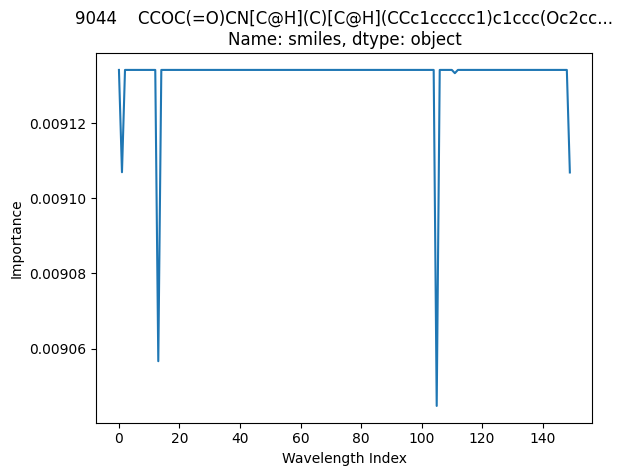

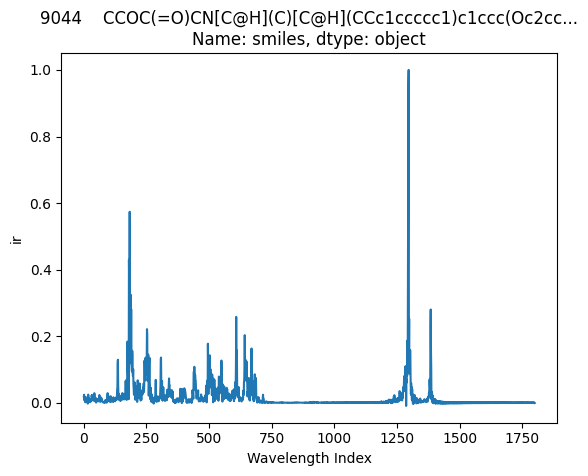

F1 Score: 0.7272727272727273
F1 Score: 0.7272727272727273


In [2]:
######初始的
import matplotlib.pyplot as plt
# 定义训练函数
def evalute_model(X_test, y_test, model_path,smiles,ir,num_fgs, weighted=False, batch_size=41, 
                annealing_epochs=10, max_lambda_kl=1.0, lambda_cmi=0.5, lambda_recon=0.1):
    device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
    model = CNNModelWithVAE(num_fgs).to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    

    # 创建 DataLoader
    y_test = np.array([np.array(item, dtype=np.float32) for item in y_test], dtype=np.float32)
    test_data = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

    
    # 评估F1分数
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch in test_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            outputs = model(inputs)
            x_pred = outputs['x']
            channal_importance_1 = outputs['channal_importance_1']
            channal_importance_2 = outputs['channal_importance_2']
            channal_importance_3 = outputs['channal_importance_3']
            channal_importance_3_cpu = channal_importance_2.squeeze().cpu().numpy()  # squeeze 去除维度 [1, 150, 1] 转为 [150, 1]



            # 步骤4: 可视化
            plt.plot(np.arange(150), channal_importance_3_cpu)
            plt.title(smiles)
            plt.xlabel('Wavelength Index')
            plt.ylabel('Importance')
            plt.show()
            
            
            plt.plot(np.arange(1800), ir)
            plt.title(smiles)
            plt.xlabel('Wavelength Index')
            plt.ylabel('ir')
            plt.show()
            
            predictions.append(x_pred.cpu().numpy())
    predictions = np.concatenate(predictions)
    binary_predictions = (predictions > 0.5).astype(int)
    f1 = f1_score(y_test, binary_predictions, average='micro')
    print(f'F1 Score: {f1}')

    return binary_predictions




# Custom loss function with class weights
class WeightedBinaryCrossEntropyLoss(nn.Module):
    def __init__(self, class_weights):
        super(WeightedBinaryCrossEntropyLoss, self).__init__()
        self.class_weights = class_weights

    def forward(self, y_pred, y_true):
        loss = self.class_weights[0] * (1 - y_true) * torch.log(1 - y_pred + 1e-15) + \
               self.class_weights[1] * y_true * torch.log(y_pred + 1e-15)
        return -loss.mean()

# Calculate class weights
def calculate_class_weights(y_true):
    num_samples = y_true.shape[0]
    class_weights = np.zeros((2, y_true.shape[1]))
    for i in range(y_true.shape[1]):
        weights_n = num_samples / (2 * (y_true[:, i] == 0).sum())
        weights_p = num_samples / (2 * (y_true[:, i] == 1).sum())
        class_weights[0, i] = weights_n
        class_weights[1, i] = weights_p
    return torch.tensor(class_weights.T, dtype=torch.float32)

# Loading data (no change)
analytical_data = Path("/data/zjh2/multimodal-spectroscopic-dataset-main/data/multimodal_spectroscopic_dataset")
out_path = Path("/home/dwj/icml_guangpu/multimodal-spectroscopic-dataset-main/runs/runs_f_groups/all_1")
columns = ["h_nmr_spectra", "c_nmr_spectra", "ir_spectra"]
seed = 3245
model_path = Path("/home/dwj/icml_guangpu/multimodal-spectroscopic-dataset-main/runs/runs_f_groups/all_1/best_model.pth")
# 准备存储合并后的数据
all_data = []
i=0
# 一次性读取文件并处理所有列
for parquet_file in analytical_data.glob("*.parquet"):
    i+=1
    # 读取所有需要的列
    data = pd.read_parquet(parquet_file, columns=columns + ['smiles'])
    # 对每个列进行插值
    for column in columns:
        data[column+"ori"] = data[column]
        data[column] = data[column].map(interpolate_to_600)
    
    # 添加功能团信息
    data['func_group'] = data.smiles.map(get_functional_groups)
    #在这里就是0/1矩阵了
    all_data.append(data)
    print(f"Loaded Data from: ", i)
    if i==3:
        break
# 合并所有数据
training_data = pd.concat(all_data, ignore_index=True)


# 将数据划分为训练集和测试集
train, test = train_test_split(training_data, test_size=1, random_state=seed)
columns = ["h_nmr_spectra", "c_nmr_spectra", "ir_spectra"]


# 提取测试集特征和标签
X_test = np.array(test[columns].values.tolist())    # 同样确保二维数组
y_test = np.array(test['func_group'].values)        # 标签一维数组
print(len(test["c_nmr_spectraori"].values.tolist()[0]))
smiles = test["smiles"]
ir = test["ir_spectraori"].values.tolist()[0]
# Train extended model
print(test['func_group'].values)
predictions = evalute_model( X_test, y_test,model_path,smiles,ir,num_fgs=37, weighted=False, batch_size=1, 
                annealing_epochs=10, max_lambda_kl=1.0, lambda_cmi=0.1, lambda_recon=0.1)

# Evaluate the model
y_test = np.array([np.array(item, dtype=np.float32) for item in y_test], dtype=np.float32)
f1 = f1_score(y_test, predictions, average='micro')
print(f'F1 Score: {f1}')

# Save results
with open(out_path / "results.pickle", "wb") as file:
    pickle.dump({'pred': predictions, 'tgt': y_test}, file)